In [1]:
import os

import re

import csv
import sqlite3
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
TEMBERTURE = sqlite3.connect("./tb.database")
PROTSTAB = pd.read_csv("./ps.database", header=None)

TB_BACTERIAS_PATH = "./tb.bacterias.csv"
TB_PROTEINS_PATH = "./tb.proteins.csv"
PS_PROTEINS_PATH = "./ps.proteins.csv"

M_ALL_ALL = "./mer.all_all.csv"
M_ALL_G60 = "./mer.all_g60.csv"
M_G60_G60 = "./mer.g60_g60.csv"

M_ALL_ALL_FA = "./mer.all_all.fasta"
M_ALL_G60_FA = "./mer.all_g60.fasta"
M_G60_G60_FA = "./mer.g60_g60.fasta"

CLU_G60_G60 = "./clu.g60_g60.csv"

CENTROIDS_G60_G60 = "./centroids.g60_g60.csv"

TRAIN = "./_train.csv"
TEST = "./_test.csv"
VAL = "./_val.csv"

# Utilitaries for Dataset

## `TemBERTure` Bacterias Dataset

In [3]:
if not os.path.isfile(TB_BACTERIAS_PATH):
    species_filter = r"(?:thermo)|(?:vulcani)|(?:calo)|(?:infern)|(?:camin)|(?:igne)|(?:torri)"
    tb_bacterias = pd.read_sql("SELECT Organism_NCBI_ID, Species, Temperature_bottom FROM bacteria", TEMBERTURE) \
        .rename(columns = {'Organism_NCBI_ID':'ncbi_id', 'Species': 'species', 'Temperature_bottom': 't_min'})
    tb_bacterias = tb_bacterias[tb_bacterias["species"].apply(lambda name: True if re.match(species_filter, name, flags=re.IGNORECASE) else False)] \
        .drop_duplicates() \
        .dropna() \
        .reset_index(drop=True)
    tb_bacterias.to_csv(TB_BACTERIAS_PATH, index=None)
else:
    tb_bacterias = pd.read_csv(TB_BACTERIAS_PATH)
    tb_bacterias["ncbi_id"] = tb_bacterias["ncbi_id"].astype(str)

## `TemBERTure` Proteins Dataset

In [4]:
if not os.path.isfile(TB_PROTEINS_PATH):
    ncbi_filter = '(' + ', '.join(tb_bacterias["ncbi_id"].apply(lambda el: f"\"{el}\"").to_list()) + ')'
    tb_proteins = pd.read_sql(f"SELECT Organism_NCBI_ID, Protein_ID, Sequence FROM fasta WHERE Organism_NCBI_ID IN {ncbi_filter}", TEMBERTURE) \
        .rename(columns = {'Organism_NCBI_ID': 'ncbi_id', 'Protein_ID': 'protein_id', 'Sequence': 'sequence'})
    tb_proteins = tb_proteins.join(tb_bacterias.set_index('ncbi_id'), on='ncbi_id')
    tb_proteins = tb_proteins[["ncbi_id", "species", "protein_id", "t_min", "sequence"]]
    tb_proteins.to_csv(TB_PROTEINS_PATH, index=None)
else:
    tb_proteins = pd.read_csv(TB_PROTEINS_PATH)
    tb_proteins["ncbi_id"] = tb_proteins["ncbi_id"].astype(str)

## `ProtStab2` Proteins Dataset

In [5]:
if not os.path.isfile(PS_PROTEINS_PATH):
    ps_proteins = PROTSTAB[[3, 1, 4, 2]].rename(columns={3: "species", 1: 'protein_id', 4: 't_min', 2: 'sequence'})
    ps_proteins.to_csv(PS_PROTEINS_PATH, index=None)
else:
    ps_proteins = pd.read_csv(PS_PROTEINS_PATH)

## Merged Proteins Datasets

In [6]:
if not os.path.isfile(M_ALL_ALL):
    proteins_all_all = pd.concat([tb_proteins, ps_proteins])
    proteins_all_all.to_csv(M_ALL_ALL, index=None)

    fasta = proteins_all_all.apply(lambda row: f">{row['ncbi_id']}__{row['protein_id']}\n{row['sequence']}", axis=1)
    fasta.to_csv(M_ALL_ALL_FA, header=None, index=None, quoting=csv.QUOTE_NONE, quotechar="",  escapechar=" ")
else:
    proteins_all_all = pd.read_csv(M_ALL_ALL)
    proteins_all_all["ncbi_id"] = proteins_all_all["ncbi_id"].astype(str)

if not os.path.isfile(M_ALL_G60):
    proteins_all_g60 = pd.concat([tb_proteins, ps_proteins[ps_proteins["t_min"]>60]])
    proteins_all_g60.to_csv(M_ALL_G60, index=None)

    fasta = proteins_all_g60.apply(lambda row: f">{row['ncbi_id']}__{row['protein_id']}\n{row['sequence']}", axis=1)
    fasta.to_csv(M_ALL_G60_FA, header=None, index=None, quoting=csv.QUOTE_NONE, quotechar="",  escapechar=" ")
else:
    proteins_all_g60 = pd.read_csv(M_ALL_G60)
    proteins_all_g60["ncbi_id"] = proteins_all_g60["ncbi_id"].astype(str)


if not os.path.isfile(M_G60_G60):
    proteins_g60_g60 = pd.concat([tb_proteins[tb_proteins["t_min"]>60], ps_proteins[ps_proteins["t_min"]>60]])
    proteins_g60_g60.to_csv(M_G60_G60, index=None)

    fasta = proteins_g60_g60.apply(lambda row: f">{row['ncbi_id']}__{row['protein_id']}\n{row['sequence']}", axis=1)
    fasta.to_csv(M_G60_G60_FA, header=None, index=None, quoting=csv.QUOTE_NONE, quotechar="",  escapechar=" ")
else:
    proteins_g60_g60 = pd.read_csv(M_G60_G60)
    proteins_g60_g60["ncbi_id"] = proteins_g60_g60["ncbi_id"].astype(str)

## MMSeqs2 Clustering

```{bash}
> cd ./data/
> mmseqs createdb mer.g60_g60.fasta mer.g60_g60.db
> mmseqs cluster mer.g60_g60.db mer.g60_g60.clusters tmp -c 0.8 --min-seq-id 0.8 -s 9.5
> mmseqs createtsv mer.g60_g60.db mer.g60_g60.db mer.g60_g60.clusters clu.g60_g60.tsv
> tar -vcf mmseqs.g60_g60.tar.gz mer.g60_g60.clusters* mer.g60_g60.db*
> rm -rf mer.g60_g60.clusters* mer.g60_g60.db*
> sed -i 's/\t/,/g' clu.g60_g60.tsv 
> mv clu.g60_g60.tsv clu.g60_g60.csv
```

In [7]:
if not os.path.isfile(CENTROIDS_G60_G60):
    if not os.path.isfile(CLU_G60_G60):
        raise FileNotFoundError("The cluster file does not exist. Please run the previous bash commands.")

    centroids_g60_g60 = pd.read_csv(CLU_G60_G60, header=None)
    centroids_g60_g60["ncbi_id"] = centroids_g60_g60[0].apply(lambda el: name if (name:=el.split('__')[0]) != "nan" else None)
    centroids_g60_g60["protein_id"] = centroids_g60_g60[0].apply(lambda el: el.split('__')[1])
    centroids_g60_g60 = centroids_g60_g60[["ncbi_id", "protein_id"]]
    centroids_g60_g60 = centroids_g60_g60.drop_duplicates()
    centroids_g60_g60 = pd.merge(centroids_g60_g60, proteins_g60_g60,  how='left', left_on=['protein_id'], right_on = ['protein_id'])
    centroids_g60_g60 = centroids_g60_g60[['ncbi_id_x', 'species', 'protein_id', 't_min', 'sequence']] \
        .rename(columns={'ncbi_id_x': 'ncbi_id'})
    centroids_g60_g60.to_csv(CENTROIDS_G60_G60, index=None)
else:
    centroids_g60_g60 = pd.read_csv(CENTROIDS_G60_G60)

## Splits

In [8]:
if (not os.path.isfile(TRAIN) or not os.path.isfile(TEST) or not os.path.isfile(VAL)):
    train, test_val = train_test_split(centroids_g60_g60, test_size=0.05, random_state=42)
    test, val = train_test_split(test_val, test_size=0.5, random_state=42)
    
    train.to_csv(TRAIN, index=None)
    test.to_csv(TEST, index=None)
    val.to_csv(VAL, index=None)
else:
    train = pd.read_csv(TRAIN)
    test = pd.read_csv(TEST)
    val = pd.read_csv(VAL)

# Tmin/Tmelt Distributions 

#proteins_all_all: 302072
#proteins_all_g60: 272082
#proteins_g60_g60: 151578
#centroids_g60_g60: 90245


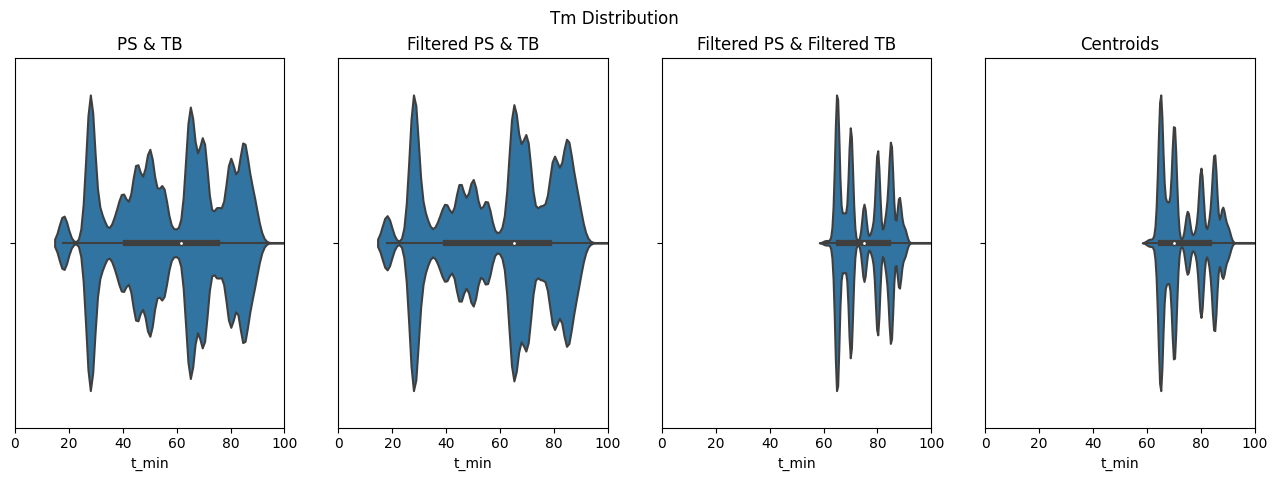

In [9]:
print(f"#proteins_all_all: {proteins_all_all.shape[0]}")
print(f"#proteins_all_g60: {proteins_all_g60.shape[0]}")
print(f"#proteins_g60_g60: {proteins_g60_g60.shape[0]}")
print(f"#centroids_g60_g60: {centroids_g60_g60.shape[0]}")

plt.close()
fig, axes = plt.subplots(1, 4)
fig.set_figwidth(16)
fig.suptitle('Tm Distribution')
[axes[i].set_xlim(0, 100) for i in range(len(axes))]
axes[0].set_title("PS & TB")
axes[1].set_title("Filtered PS & TB")
axes[2].set_title("Filtered PS & Filtered TB")
axes[3].set_title("Centroids")
sns.violinplot(data=proteins_all_all, x="t_min", ax=axes[0])
sns.violinplot(data=proteins_all_g60, x="t_min", ax=axes[1])
sns.violinplot(data=proteins_g60_g60, x="t_min", ax=axes[2])
sns.violinplot(data=centroids_g60_g60, x="t_min", ax=axes[3])
plt.show()

#train: 85732
#test: 2256
#val: 2257


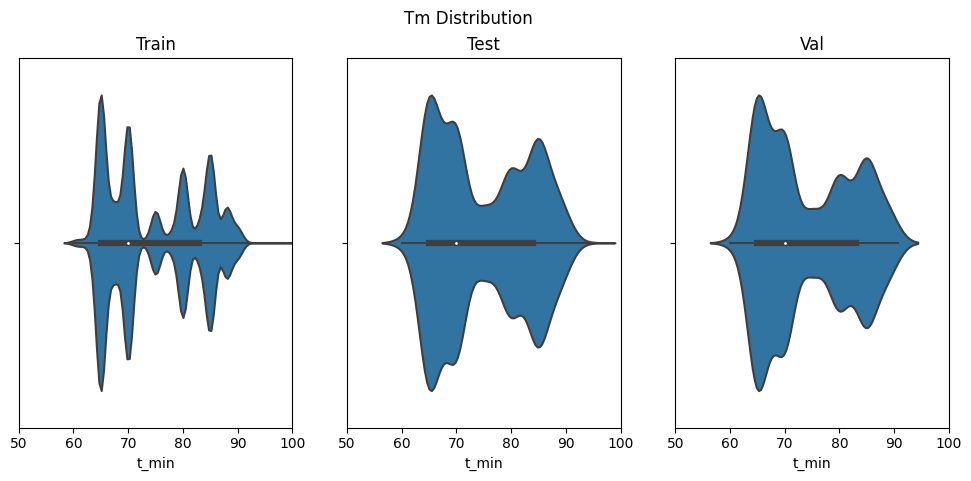

In [10]:
print(f"#train: {train.shape[0]}")
print(f"#test: {test.shape[0]}")
print(f"#val: {val.shape[0]}")

plt.close()
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(12)
fig.suptitle('Tm Distribution')
[axes[i].set_xlim(50, 100) for i in range(len(axes))]
axes[0].set_title("Train")
axes[1].set_title("Test")
axes[2].set_title("Val")
sns.violinplot(data=train, x="t_min", ax=axes[0])
sns.violinplot(data=test, x="t_min", ax=axes[1])
sns.violinplot(data=val, x="t_min", ax=axes[2])
plt.show()